# STA365 HW4
## Lisa Wang

### Q1
**Question:** 

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

**Answer:** 

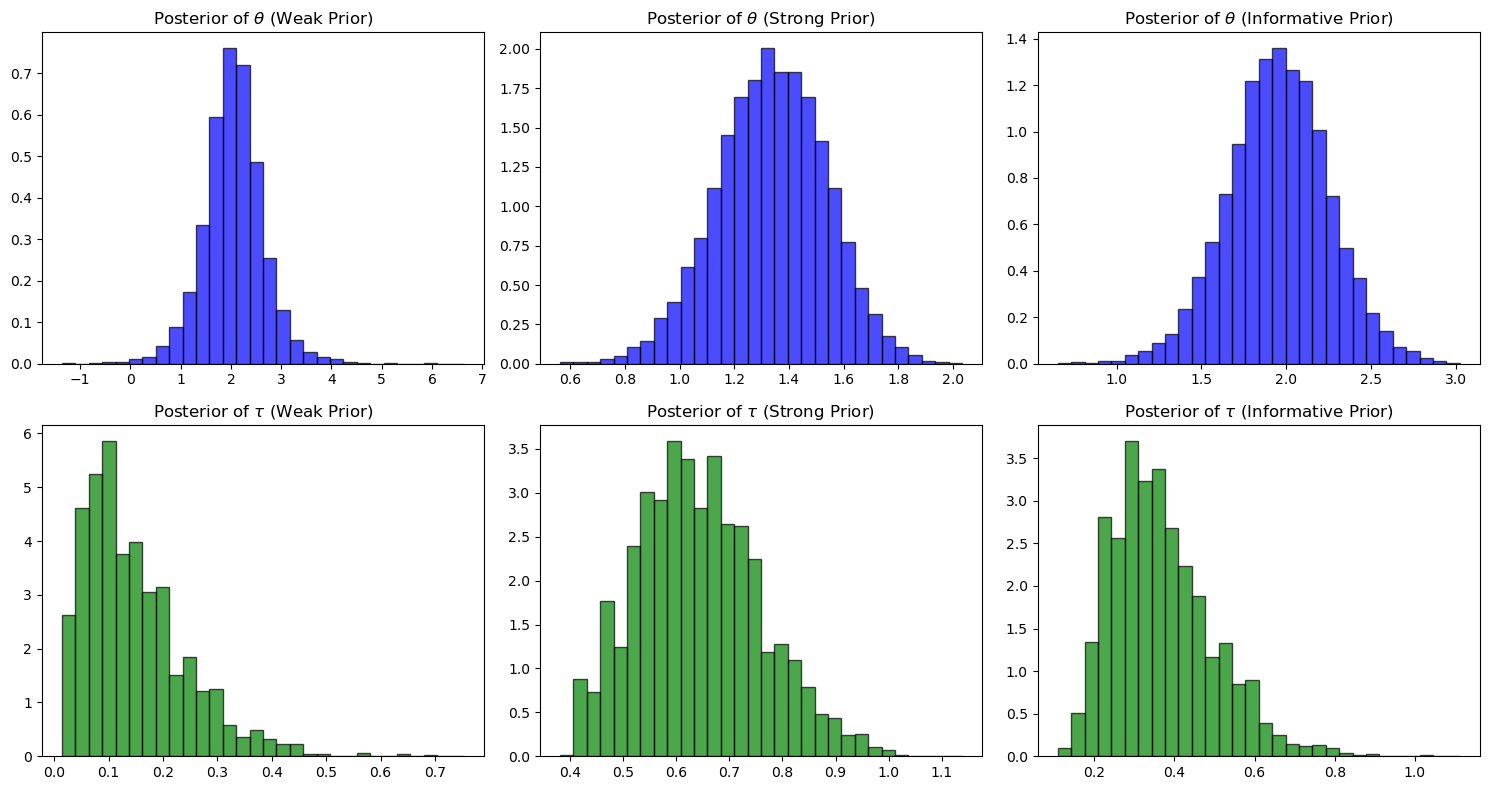

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

# Sample data
n = 30
x = np.random.normal(loc=2, scale=1, size=n)  # Data generated with mean 2

# Define different prior settings
prior_settings = [
    {"theta_0": np.mean(x), "tau_0_sq": 100, "alpha": 2, "lambda": 2, "label": "Weak Prior"},
    {"theta_0": 0, "tau_0_sq": 0.1, "alpha": 20, "lambda": 20, "label": "Strong Prior"},
    {"theta_0": 1, "tau_0_sq": 1, "alpha": 5, "lambda": 5, "label": "Informative Prior"}
]

num_iter = 10000
burn_in = 1000

fig, ax = plt.subplots(2, len(prior_settings), figsize=(15, 8))

# Run Metropolis within Gibbs sampler for each prior setting
for i, setting in enumerate(prior_settings):
    theta_0, tau_0_sq, alpha, lambda_ = list(setting.values())[:4]
    
    theta_samples = np.zeros(num_iter)
    tau_samples = np.zeros(num_iter)
    
    theta_samples[0] = np.mean(x)
    tau_samples[0] = 1 / np.var(x)

    for j in range(1, num_iter):
        
        # ---- Metropolis-Hastings Step for τ ----
        tau_current = tau_samples[j - 1]
        tau_proposed = gamma.rvs(a=alpha, scale=1/lambda_)  # (gamma proposal)

        # Compute acceptance probability
        log_p_tau_current = (alpha - 1) * np.log(tau_current) - lambda_ * tau_current - (tau_current * np.sum((x - theta_samples[j - 1])**2)) / 2
        log_p_tau_proposed = (alpha - 1) * np.log(tau_proposed) - lambda_ * tau_proposed - (tau_proposed * np.sum((x - theta_samples[j - 1])**2)) / 2
        acceptance_ratio = np.exp(log_p_tau_proposed - log_p_tau_current)

        if np.random.uniform() < acceptance_ratio:
            tau_samples[j] = tau_proposed
        else:
            tau_samples[j] = tau_current

        # ---- Gibbs Sampling Step for θ ----
        mu_theta = (tau_samples[j] * n * np.mean(x) + (1 / tau_0_sq) * theta_0) / (tau_samples[j] * n + (1 / tau_0_sq))
        sigma_theta_sq = 1 / (tau_samples[j] * n + (1 / tau_0_sq))
        theta_samples[j] = norm.rvs(mu_theta, np.sqrt(sigma_theta_sq))

    # Burn-in period
    theta_samples = theta_samples[burn_in:]
    tau_samples = tau_samples[burn_in:]

    # Plot posteriors
    ax[0, i].hist(theta_samples, bins=30, alpha=0.7, color="blue", edgecolor="black", density=True)
    ax[0, i].set_title(f"Posterior of $\\theta$ ({setting['label']})")
    
    ax[1, i].hist(tau_samples, bins=30, alpha=0.7, color="green", edgecolor="black", density=True)
    ax[1, i].set_title(f"Posterior of $\\tau$ ({setting['label']})")

plt.tight_layout()
plt.show("png")

**Comparison Between Gibbs Sampler and Metropolis within Gibbs:**

Both methods samples from the same posterior distribution of $\theta$ and $\tau$. However, there are differences in effciency and convergence due to the way each method generates samples. 

The Gibbs sampler samples directly from teh full conditional distribution, ensuring every sample is accepted. The metropolis within Gibbs sample uses a proposal distribution of $\tau$ and some proposals get rejected, which could slow down sampling. 
The rejections caused higher autocorrelation in the Markov Chain, as shown from the more spread-out posterior distribution of $\tau$ in the Metropolis within Gibbs result. 

The gibbs sampler posterior were more concentrated, suggesting better sampling efficiency. Since the full conditional distributions are known and easy to sample from, Gibbs seems to be a better choice in this case. 

### Q2
**Question:** 

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.Inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof)  of analytically determining the full conditional distributions when using Metropolis-Hastings.*

**Answer:** 

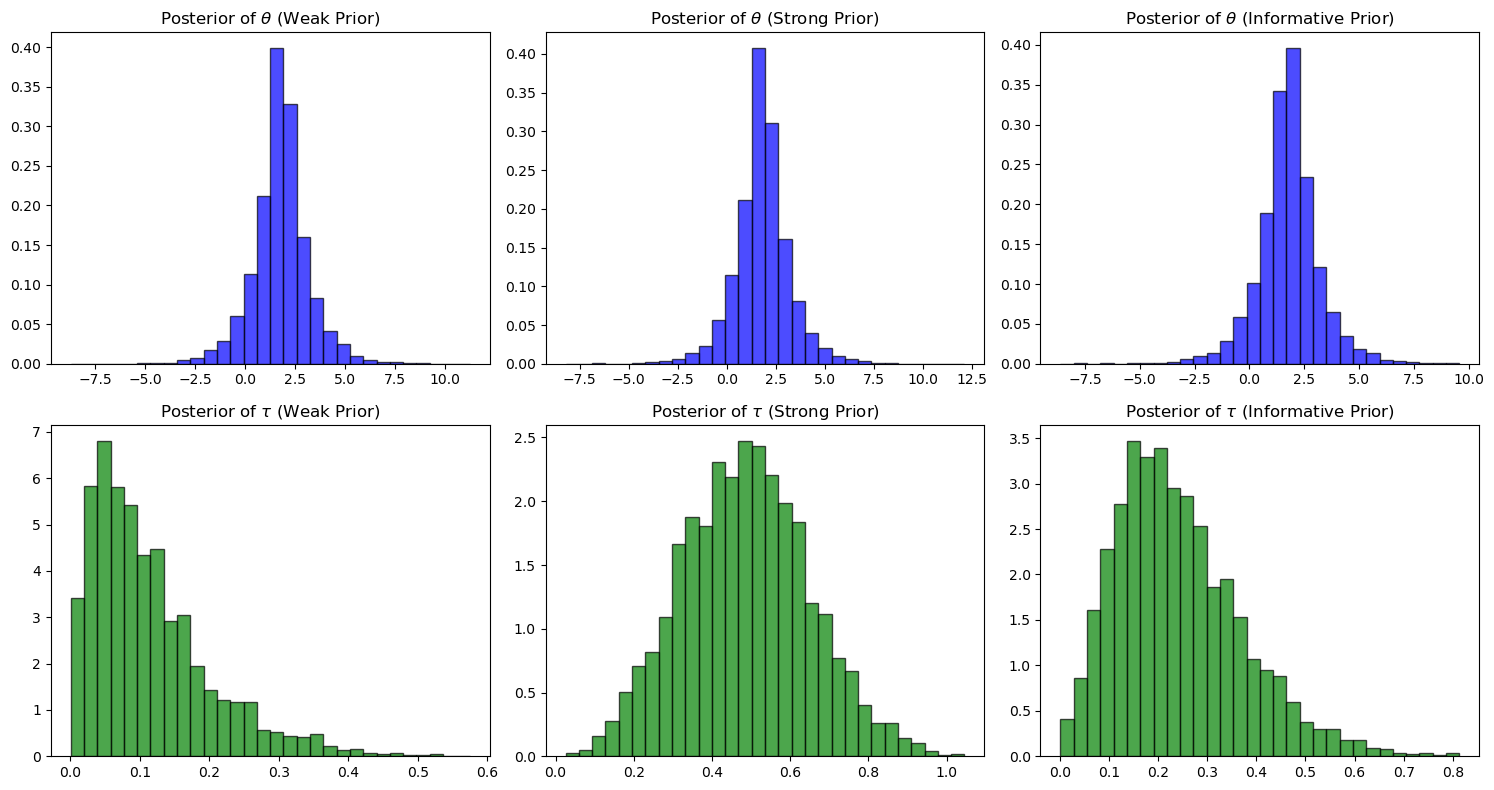

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, laplace, gamma

# Sample data
n = 30
x = np.random.normal(loc=2, scale=1, size=n)  # Data generated with mean 2

# Define different prior settings
prior_settings = [
    {"theta_0": np.median(x), "tau_0_sq": 100, "alpha": 2, "lambda": 2, "s": 0.5, "label": "Weak Prior"},
    {"theta_0": 0, "tau_0_sq": 0.1, "alpha": 20, "lambda": 20, "s": 0.2, "label": "Strong Prior"},
    {"theta_0": 1, "tau_0_sq": 1, "alpha": 5, "lambda": 5, "s": 0.3, "label": "Informative Prior"}
]

num_iter = 10000
burn_in = 1000

fig, ax = plt.subplots(2, len(prior_settings), figsize=(15, 8))

# Run Metropolis within Gibbs sampler for each prior setting
for i, setting in enumerate(prior_settings):
    theta_0, tau_0_sq, alpha, lambda_, s = list(setting.values())[:5]
    
    theta_samples = np.zeros(num_iter)
    tau_samples = np.zeros(num_iter)
    
    theta_samples[0] = np.median(x)  # Use median (sincew prior is Laplace)
    tau_samples[0] = 1 / np.var(x)

    for j in range(1, num_iter):
        
        # ---- Metropolis-Hastings Step for τ using a dependent proposal ----
        tau_current = tau_samples[j - 1]
        
        # Truncated (at 0) normal proposal 
        a, b = -tau_current / s, np.inf 
        tau_proposed = truncnorm.rvs(a, b, loc=tau_current, scale=s)
        
        # Compute acceptance probability
        log_p_tau_current = (alpha - 1) * np.log(tau_current) - lambda_ * tau_current - (tau_current * np.sum((x - theta_samples[j - 1])**2)) / 2
        log_p_tau_proposed = (alpha - 1) * np.log(tau_proposed) - lambda_ * tau_proposed - (tau_proposed * np.sum((x - theta_samples[j - 1])**2)) / 2
        acceptance_ratio = np.exp(log_p_tau_proposed - log_p_tau_current)

        if np.random.uniform() < acceptance_ratio:
            tau_samples[j] = tau_proposed
        else:
            tau_samples[j] = tau_current

        # ---- Gibbs Sampling Step for θ with Laplace Prior ----
        b_theta = 1  # Scale parameter for Laplace prior
        mu_theta = np.median(x)  # Use median instead of mean
        theta_samples[j] = laplace.rvs(loc=mu_theta, scale=b_theta)

    # Burn-in period
    theta_samples = theta_samples[burn_in:]
    tau_samples = tau_samples[burn_in:]

    # Plot posteriors
    ax[0, i].hist(theta_samples, bins=30, alpha=0.7, color="blue", edgecolor="black", density=True)
    ax[0, i].set_title(f"Posterior of $\\theta$ ({setting['label']})")
    
    ax[1, i].hist(tau_samples, bins=30, alpha=0.7, color="green", edgecolor="black", density=True)
    ax[1, i].set_title(f"Posterior of $\\tau$ ({setting['label']})")

plt.tight_layout()
plt.show("png")

The use of a truncated normal proposal for $\tau$ ensures smoother transitions between sampled values, but it also introduces autocorrelation, which can slow down mixing. Meanwhile, employing a Laplace prior for $\theta$ results in more concentrated posterior samples around the median and provides greater robustness to outliers compared to a normal prior. 

When considering the necessity of full conditional distributions, they are preferable when they are easy to derive and sample from. However, in cases where they are complex or lack a standard form, Metropolis-Hastings offers greater flexibility. In this scenario, Gibbs sampling would have been more efficient since $\tau$ could be sampled directly from a gamma distribution. However, by requiring a dependent proposal where full conditional sampling is not possible, the adaptability of Metropolis-Hastings is more preferred. 

### Q3
**Question:** 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

**Answer:** 

The Metropolis-Hastings transition probabilities are given by:

$$
K(x \to x') = q(x' | x) A(x' | x)
$$

where $x = x^{(t)}$, $x' = x^{(t+1)}$.

- Proposal distribution: \( q(x' | x) \)
- Acceptance probability: \( A(x' | x) \)

Since $q(x' | x)$ is symmetric, the proposal ratio cancels out:

$$
\frac{q(x^{(t+1)} | x^{(t)})}{q(x^{(t)} | x^{(t+1)})} = \frac{1/2}{1/2} = 1
$$

Thus, the acceptance probability simplifies to:

$$
A(x' | x) = \min \left( 1, \frac{P(x')}{P(x)} \right)
$$

**Transition Proabbilities Calculations**

**Transition: $x = 0 \to x' = 1$**

- $q(1 | 0) = \frac{1}{2}$
- $A(1 | 0) = \min \left( 1, \frac{P(1)}{P(0)} \right) = \min \left( 1, \frac{2/3}{1/3} \right) = \min(1,2) = 1$

Thus:

$$
K(0 \to 1) = q(1 | 0) A(1 | 0) = \frac{1}{2} \times 1 = 0.5
$$

**Transition: $x = 0 \to x' = 0$**

$$
K(0 \to 0) = 1 - K(0 \to 1) = 1 - 0.5 = 0.5
$$

**Transition: $x = 1 \to x' = 0$**

- $q(0 | 1) = \frac{1}{2}$
- $A(0 | 1) = \min \left( 1, \frac{P(0)}{P(1)} \right) = \min \left( 1, \frac{1/3}{2/3} \right) = \min(1, 0.5) = 0.5$

Thus:

$$
K(1 \to 0) = \frac{1}{2} (0.5) = 0.25
$$

**Transition: $x = 1 \to x' = 1$**

$$
K(1 \to 1) = 1 - K(1 \to 0) = 1 - 0.25 = 0.75
$$

Putting everything together, we obtain:

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$